#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [306]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [307]:
#считываем датасет, переводим object в datetime и меняем индексы
data = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])

In [308]:
#проверяем хронологический порядок
data.index.is_monotonic

True

In [309]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [310]:
data.head(6)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21


In [311]:
#делаем ресемплирование по 1 часу, агрегируем с помощью суммы
df = data.copy()
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**- Данные загружены корректно.**  
**- Пропусков нет.**  
**- Данные разложены в хронологическом порядке.**  
**- Произведено ресемплирование по 1 часу, агрегирование по сумме.**

## Анализ

In [312]:
df['rolling_mean'] = df['num_orders'].shift().rolling(24).mean()
df['std'] = df['num_orders'].rolling(24).std()

<AxesSubplot:xlabel='datetime'>

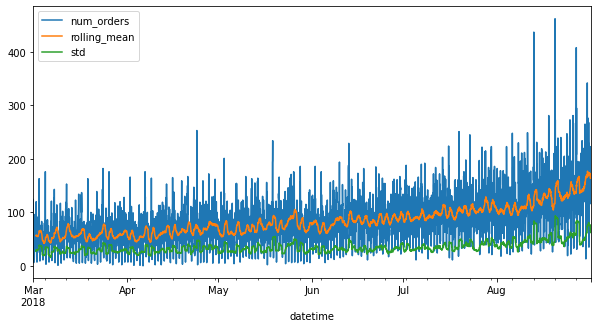

In [313]:
df[['num_orders', 'rolling_mean', 'std']].plot(figsize=(10,5))

**- Среднее значение и стандартное отклонение увеличиваются со временем**  
**- Временной ряд нестационарный**  
**- На графике видно, что количество заказов растет от месяца к месяцу**

In [314]:
#удалим добавленные колонки. Они не нужны нам в дальнейшем ни для анализа, ни для потсроения модели
df=df.drop(['rolling_mean', 'std'], axis=1)

<AxesSubplot:title={'center':'Trend'}, xlabel='datetime'>

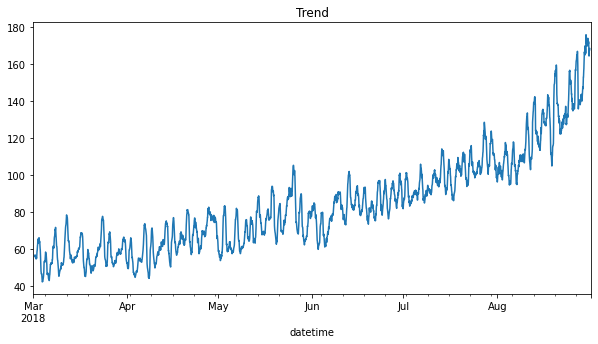

In [315]:
decomposed_df = seasonal_decompose(df)
decomposed_df.trend.plot(title='Trend', figsize=(10,5))

<AxesSubplot:title={'center':'Seasonal'}, xlabel='datetime'>

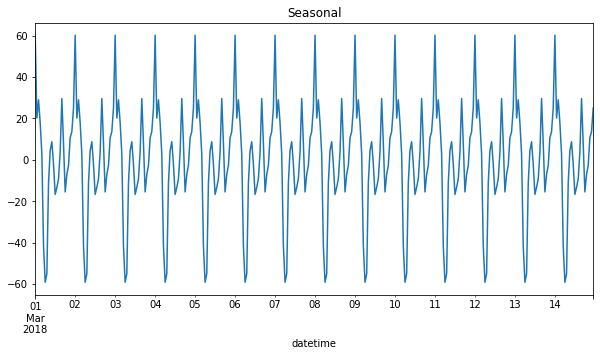

In [316]:
#построим график сезонности с группировкой по 12 часов за первые 2 недели
decomposed_df.seasonal.head(12*28).plot(title='Seasonal', figsize=(10,5), ax=plt.gca())

**на графиках видно, что:**  
**- имется восходящий тренд**  
**- есть "сезонность" в рамках 1-го дня**

In [317]:
#ищем 3 дня, когда количество поездок было максимальным
day = df.resample('3D').sum()
print(day[day.num_orders == day.num_orders.max()])

            num_orders
datetime              
2018-08-28       11209


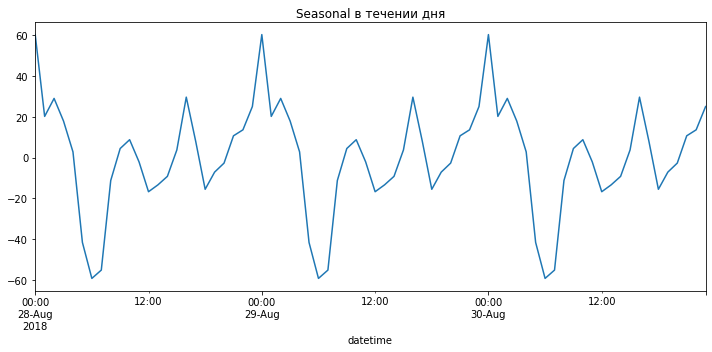

In [318]:
plt.figure(figsize=(10, 5))
decomposed_df.seasonal['2018-08-28':'2018-08-30'].plot(ax=plt.gca())
plt.title('Seasonal в течении дня')
plt.tight_layout()

**Есть провалы в 6 утра и пиковые нагрузки в районе 10, 16 часов и в полночь**  
**Есть множество причин такой зависимости, например:**  
**- расписание работы общественного транспорта**  
**- расписание рейсов, так как мы рассматриваем такси до аэропорта**  
**Проверить на корректность эти пики у нас нет возможности, поэтому принимаем их за норму.**

## Обучение

In [319]:
#за основу берем почасовой суточный лаг, и сглаживание в 6-часовом диапазоне.
LAG = 24
ROL = 6

df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour
for i in range(1, LAG + 1):
    df['lag_{}'.format(i)] = df['num_orders'].shift(i)
df['rolling_mean'] = df['num_orders'].shift().rolling(ROL).mean()
df.dropna(inplace=True)
df.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,0,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,69.333333
2018-03-02 01:00:00,120,3,2,4,1,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,72.166667
2018-03-02 02:00:00,75,3,2,4,2,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,84.666667
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,87.000000
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,86.666667


In [320]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [321]:
print(features_train.shape, features_train.index.min(), features_train.index.max())
print(features_test.shape, features_test.index.min(), features_test.index.max())

(3952, 29) 2018-03-02 00:00:00 2018-08-13 15:00:00
(440, 29) 2018-08-13 16:00:00 2018-08-31 23:00:00


## Тестирование

In [322]:
RS = 12345
CV = TimeSeriesSplit(n_splits=3)
value = []

In [323]:
#функция для обучения модели и расчета RMSE
def train_rmse(model):
    model.fit(features_train, target_train)
    train_pred = model.predict(features_train)
    test_pred = model.predict(features_test)
    rmse_train = mean_squared_error(target_train, train_pred)**0.5
    rmse_test = mean_squared_error(target_test, test_pred)**0.5
    print("RMSE обучающей выборки:", rmse_train)
    print("RMSE тестовой выборки: ", rmse_test)
    return rmse_train, rmse_test

In [324]:
#функия для подбора значений заданных гиперпараметров
def grid (model, param):
    print ('C гиперпараметрами:')
    grid_search = GridSearchCV(estimator = model,
                          param_grid = param,
                          cv=CV,
                          scoring='neg_mean_squared_error')
    grid_search.fit(features_train, target_train)
    print('Лучшие гиперпараметры: ', grid_search.best_params_)
    return train_rmse (grid_search.best_estimator_)

### LASSO

In [325]:
lrg = Lasso (random_state = RS)

In [326]:
%%time
print ('Без гиперпараметров:')
value.append(train_rmse(lrg))

Без гиперпараметров:
RMSE обучающей выборки: 25.75724181499572
RMSE тестовой выборки:  45.36573799502852
CPU times: user 96 ms, sys: 77.1 ms, total: 173 ms
Wall time: 139 ms


In [327]:
lrg_param = {
    'fit_intercept':[True,False],
    'normalize':[True,False],
    'copy_X':[True, False]
}

In [328]:
%%time
value.append(grid(lrg, lrg_param))

C гиперпараметрами:
Лучшие гиперпараметры:  {'copy_X': True, 'fit_intercept': False, 'normalize': True}
RMSE обучающей выборки: 25.779725085645186
RMSE тестовой выборки:  45.32659867320945
CPU times: user 3.38 s, sys: 4.4 s, total: 7.78 s
Wall time: 7.8 s


### Cat Boost

In [329]:
cat = CatBoostRegressor( random_state = RS, verbose = False)

In [330]:
%%time
print ('Без гиперпараметров:')
value.append(train_rmse(cat))

Без гиперпараметров:
RMSE обучающей выборки: 10.743804160605881
RMSE тестовой выборки:  39.434886628052745
CPU times: user 6.7 s, sys: 130 ms, total: 6.83 s
Wall time: 8.83 s


In [331]:
cat_param = {
    'depth' : [2, 5, 10],
    'n_estimators': [100, 250, 500],
}

In [332]:
%%time
value.append(grid(cat, cat_param))

C гиперпараметрами:
Лучшие гиперпараметры:  {'depth': 5, 'n_estimators': 500}
RMSE обучающей выборки: 13.617945086465992
RMSE тестовой выборки:  39.31440073240048
CPU times: user 1min 56s, sys: 1.06 s, total: 1min 57s
Wall time: 2min 41s


### LightGBM

In [333]:
lgb = LGBMRegressor(random_state = RS, force_col_wise=True)

In [334]:
%%time
print ('Без гиперпараметров:')
value.append(train_rmse(lgb))

Без гиперпараметров:
RMSE обучающей выборки: 12.264536774570061
RMSE тестовой выборки:  40.291535102480765
CPU times: user 42.5 s, sys: 412 ms, total: 42.9 s
Wall time: 43.3 s


In [335]:
lgb_param = {
    'learning_rate' : [0.05, 0.1, 0.2],
    'n_estimators' : [50, 100, 200]
}

In [336]:
%%time
value.append(grid(lgb, lgb_param))

C гиперпараметрами:
Лучшие гиперпараметры:  {'learning_rate': 0.05, 'n_estimators': 200}
RMSE обучающей выборки: 12.180696984104978
RMSE тестовой выборки:  39.63701973845369
CPU times: user 25min 16s, sys: 12.8 s, total: 25min 29s
Wall time: 25min 42s


### Выводы

In [337]:
pd.DataFrame(data=value,
             index=[' LASSO без гиперпараметров',
                    ' LASSO с гиперпараметрами',
                    ' Cat Boost без гиперпараметров',
                    ' Cat Boost с гиперпараметрами',
                    ' LightGBM без гиперпараметров',
                    ' LightGBM с гиперпараметрами'],
             columns=['RMSE обучающая выборка', 'RMSE тестовая выборка'])

,RMSE обучающая выборка,RMSE тестовая выборка
LASSO без гиперпараметров,25.757242,45.365738
LASSO с гиперпараметрами,25.779725,45.326599
Cat Boost без гиперпараметров,10.743804,39.434887
Cat Boost с гиперпараметрами,13.617945,39.314401
LightGBM без гиперпараметров,12.264537,40.291535
LightGBM с гиперпараметрами,12.180697,39.637020


**- обучили 3 различные модели**  
**- видно, что происходит "переобучение" модели, так как разница RMSE при обучении и на тесте различается в 2-4 раза**
**- однако все модели на тесте укладываются в значении метрики RMSE = 48**  
**- самая точная модель - CatBoost**  
**- однако, если нет требований по улучшению качества предсказания и устраивает метрика размеров в 48, порекомендовал бы модель LASSO как значительно более быструю, чем остальные.**